In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from obspy.taup import TauPyModel
from obspy.geodetics import degrees2kilometers, kilometer2degrees, gps2dist_azimuth
from mudpy import forward

In [3]:
path = '/Users/sydneydybing/SW4/strain/experiments/realistic_eq_sizes/'
stas = pd.read_csv(path + 'stas_w_p_s_traveltimes.csv')
hypo_lat = 35.7793
hypo_lon = -117.6204
hypo_depth = 7.5
stas

,name,lon,lat,hypo_dist_km,p_arrival,s_arrival
0,E1,-118.5,35.0,117.735516,19.484985,33.835013
1,E2,-118.5,35.1,109.811069,18.258040,31.667682
2,E3,-118.5,35.2,102.476405,17.099509,29.636367
3,E4,-118.5,35.3,95.867056,16.055540,27.802686
4,E5,-118.5,35.4,90.142773,15.151369,26.214599
...,...,...,...,...,...,...
318,E319,-116.7,36.2,95.223479,15.953885,27.624136
319,E320,-116.7,36.3,101.083463,16.879489,29.249912
320,E321,-116.7,36.4,107.770552,17.935735,31.105169
321,E322,-116.7,36.5,115.140783,19.089840,33.125357


In [8]:
# # Add a column to the stations dataframe with the theoretical P-wave arrival times

# custom_model = TauPyModel(model = '/Users/sydneydybing/SW4/strain/structure/mojave_simpletop_forsw4.npz')

# dists_km = []
# p_arr_times = []
# s_arr_times = []

# for idx in range(len(stas)):
    
#     sta_lat = stas.lat.values[idx]
#     sta_lon = stas.lon.values[idx]
#     dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters
    
#     arrivals = custom_model.get_travel_times(source_depth_in_km = hypo_depth, 
#                                   distance_in_degree = kilometer2degrees(dist_m/1000), phase_list=['s', 'S'])
#     # print(arrivals)
#     # p_arr_time = arrivals[0].time
#     s_arr_time = arrivals[0].time
    
#     s_arr_times.append(s_arr_time)
#     # dists_km.append(dist_m/1000)

# # stas['hypo_dist_km'] = dists_km
# # stas['p_arrival'] = p_arr_times
# stas['s_arrival'] = s_arr_times

# stas.to_csv(path + 'stas_w_p_s_traveltimes.csv', index = False)

/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_4884/1496575706.py:13: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters


In [4]:
files_list = os.listdir(path)
# print(files_list)

rupts_list = []
for file in files_list:
    if file[-4:] == 'rupt':
        rupts_list.append(file)

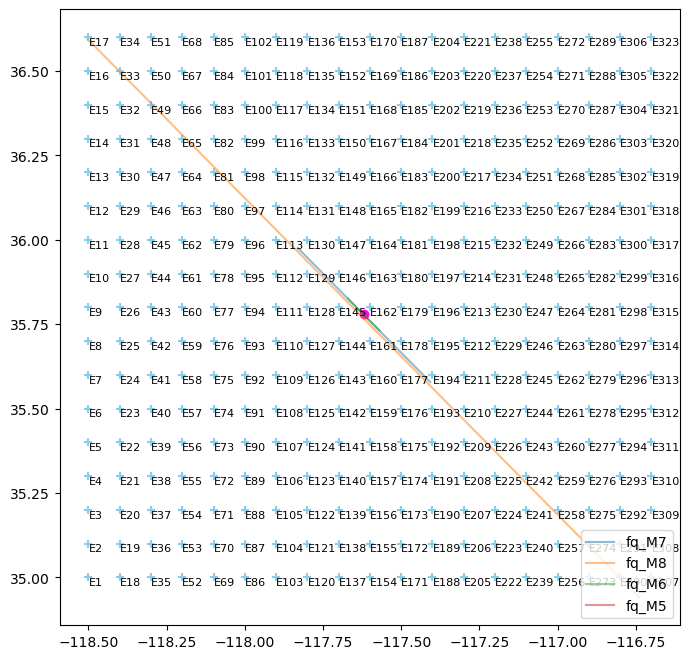

In [5]:
fig = plt.figure(figsize = (8, 8))

plt.scatter(hypo_lon, hypo_lat, color = 'magenta')
plt.scatter(stas.lon, stas.lat, marker = '+', color = 'skyblue')
[plt.text(i, j, f'{name}', va = 'top', ha = 'left', fontsize = 8) for (i, j, name) in zip(stas.lon, stas.lat, stas.name)]

for idx in range(len(rupts_list)):
    
    rupt = np.genfromtxt(path + rupts_list[idx])
    sf_lons = rupt[:,1]
    sf_lats = rupt[:,2]

    # Fault extent
    min_lon = min(sf_lons)
    max_lon = max(sf_lons)
    min_lat = min(sf_lats)
    max_lat = max(sf_lats)
    
    plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'C' + str(idx), label = rupts_list[idx][:5], alpha = 0.5)    
    
plt.legend(loc = 'lower right')

plt.show();

['E144']


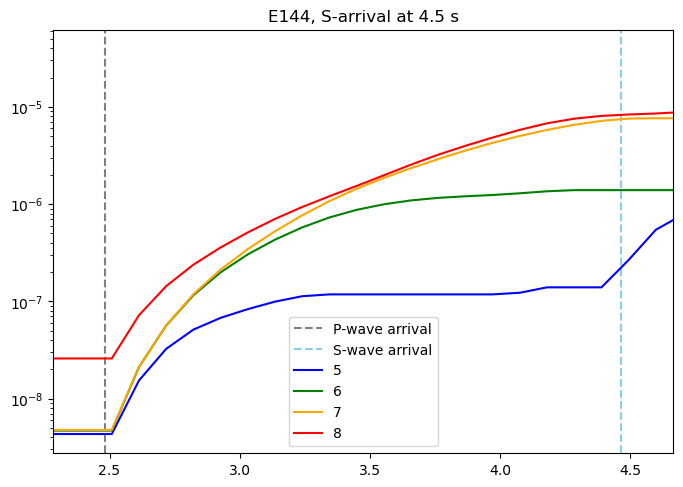

['E126']


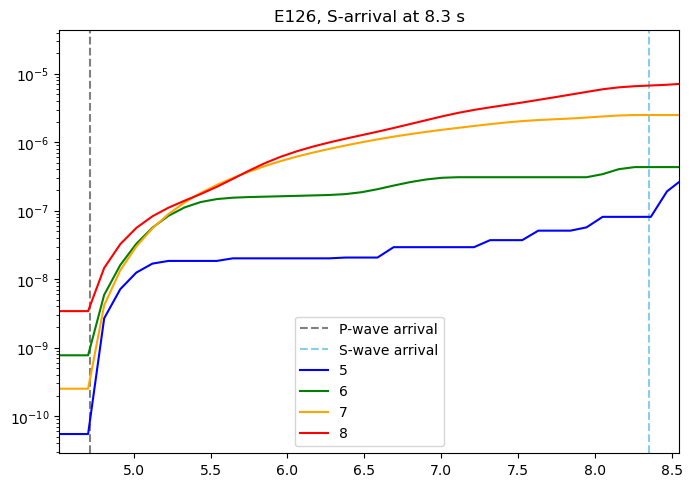

['E108']


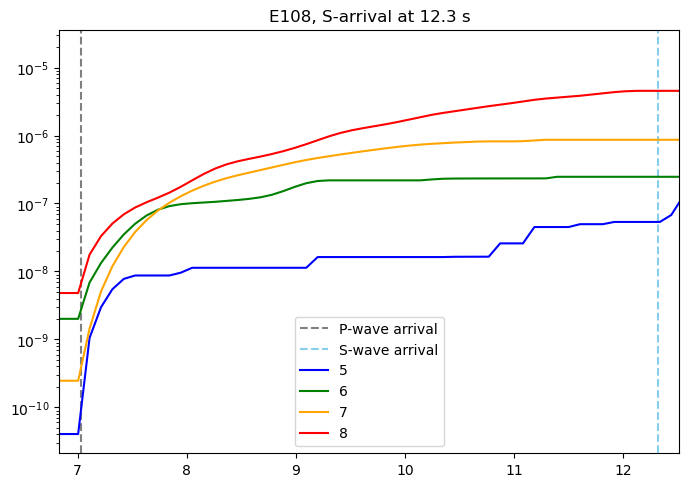

['E90']


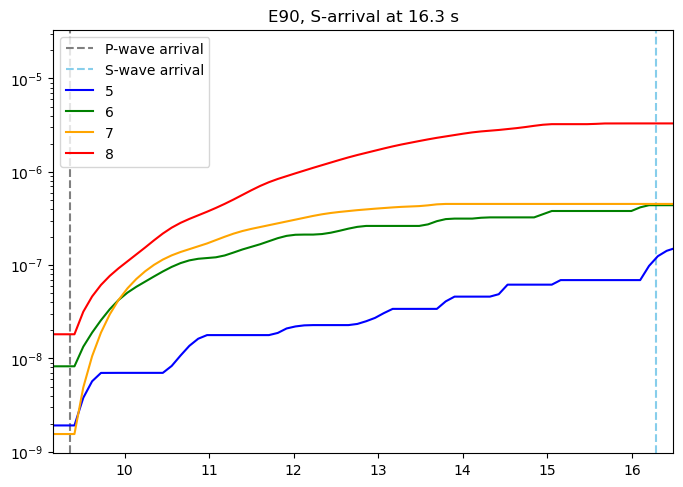

['E72']


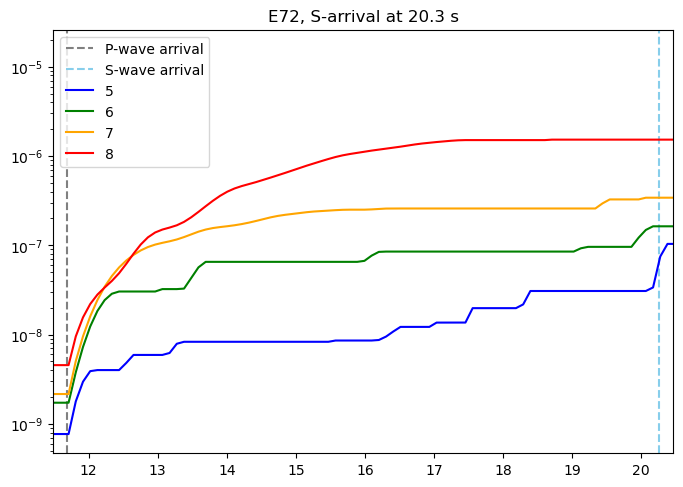

['E54']


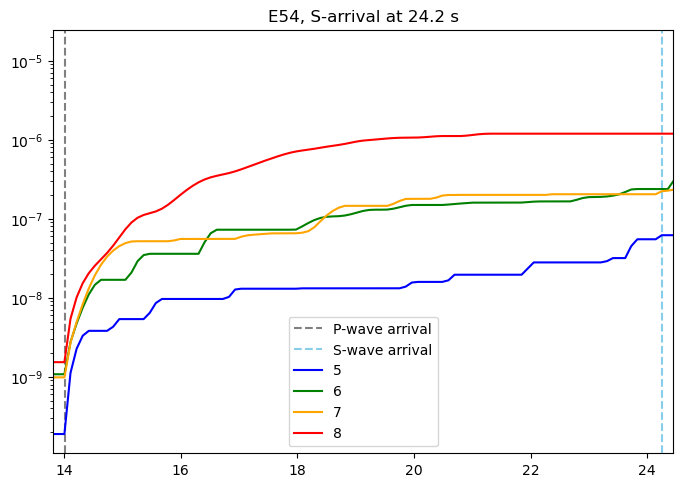

['E36']


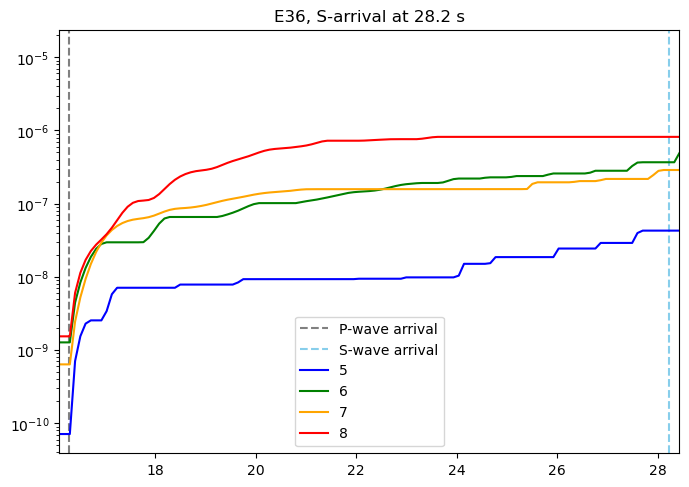

['E18']


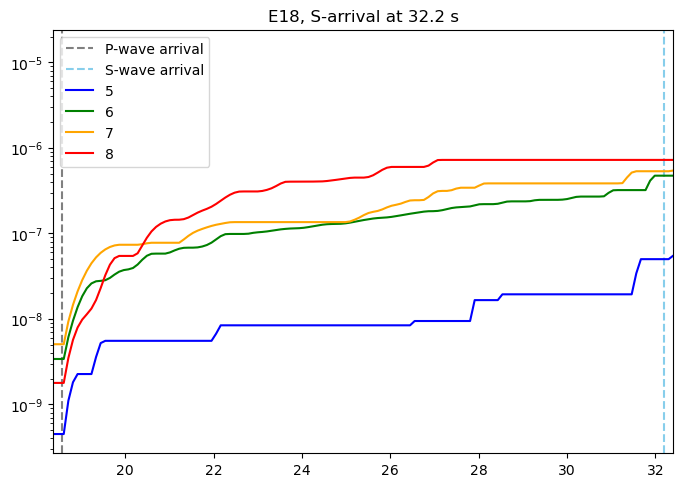

In [54]:
stas_sub = ['E144', 'E126', 'E108', 'E90', 'E72', 'E54', 'E36', 'E18']
Mws = [5, 6, 7, 8]
colors = ['blue', 'green', 'orange', 'red']

for idx in range(len(stas_sub)):

    sta = stas_sub[idx]

    i = np.where(stas.name.values == sta)[0]
    print(stas.name.values[i])
    hypdist = stas.hypo_dist_km.values[i][0]
    theo_p_arr = stas.p_arrival.values[i][0]
    theo_s_arr = stas.s_arrival.values[i][0]

    fig = plt.figure(figsize = (8,5.5), dpi = 100, facecolor = 'white')
    ax = fig.add_subplot(111)
    ax.set_title(sta + ', S-arrival at ' + str(round(theo_s_arr,1)) + ' s')
    ax.axvline(theo_p_arr, color = 'gray', linestyle = '--', label = 'P-wave arrival')
    ax.axvline(theo_s_arr, color = 'skyblue', linestyle = '--', label = 'S-wave arrival')

    for idx2 in range(len(Mws)):
        
        Mw = Mws[idx2]
        color = colors[idx2]

        model_path = path + 'talapas_outputs/M' + str(Mw) + '_results/'
        
        strain_path = model_path + sta + 's.txt'
        disp_path = model_path + sta + 'd.txt'

        time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain, norm_peak_strain = process_strain(strain_path, theo_p_arr)
        time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss, norm_peak_gnss = process_disp(disp_path, theo_p_arr)
        
        both_rms_strain = np.column_stack((time_strain, rms_strain))
        np.save(path + 'npys_for_mcmc/M' + str(Mw) + '/filter_rms_strain/' + str(sta) + '.npy', both_rms_strain)

        both_peak_strain = np.column_stack((time_strain, peak_strain))
        np.save(path + 'npys_for_mcmc/M' + str(Mw) + '/filter_peak_strain/' + str(sta) + '.npy', both_peak_strain)
        
        both_norm_peak_strain = np.column_stack((time_strain, norm_peak_strain))
        np.save(path + 'npys_for_mcmc/M' + str(Mw) + '/filter_norm_peak_strain/' + str(sta) + '.npy', both_peak_strain)

        ax.plot(time_strain, peak_strain, color = color, label = Mw)
        # ax.plot(time_strain, xy_strain, color = color, label = Mw)
        # ax.set_xlim(0, theo_p_arr+10)
        # ax.set_yscale('log')
        # plt.show()
        # ax2 = ax.twinx()
        # ax2.plot(time_gnss, norm_peak_gnss, color = color, linestyle = '--', label = Mw)
        
    ax.set_yscale('log')
    # # ax2.set_yscale('log')
    ax.set_xlim(theo_p_arr-0.2, theo_s_arr+0.2)
    # ax.set_ylim(0,0.2*10**-5)
    ax.legend()
    plt.show()




In [ ]:
# Steeper slope in log-space for higher magnitudes
# Later transition time in log-space for higher magnitudes
# Strong determinism shows up in these models, but not in real life

In [52]:
### Process strain data ###

def process_strain(strain_data, theoretical_p_arrival):
    
    strain = pd.read_csv(strain_path, sep = '\s+', skiprows = 16, names = ['time', 'xx', 'yy', 'zz', 'xy', 'xz', 'yz'])

    # Calculate horizontal RMS strain
    time_strain = strain.time.values
    xx_strain = strain.xx.values
    xy_strain = strain.xy.values
    yy_strain = strain.yy.values
    
    rms_strain = np.sqrt((xx_strain**2 + xy_strain**2 + yy_strain**2)/3)

    # Calculate peak strain
    strain_p_i = np.abs(time_strain - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_strain = rms_strain.copy()
    p_arr_strain = rms_strain[strain_p_i]
    mod_rms_strain[:strain_p_i] = p_arr_strain # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_strain = mod_rms_strain.copy()
    for k in range(0,len(mod_rms_strain)):
        if k == 0:
            strain = mod_rms_strain[0]
            max_strain = strain
        else:
            # Grab progressively longer windows and save the biggest strain
            strain = mod_rms_strain[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_strain = max(strain)
        # Put peak strain back into the output stream
        peak_strain[k] = max_strain 
    
    # Normalize to 10**-9
    norm_peak_strain = np.copy(peak_strain)
    norm_peak_strain_level = peak_strain[0]
    norm_peak_strain = norm_peak_strain - norm_peak_strain_level + 1*10**-9
    
    # Filtering stuff
    
    max_time = max(time_strain)
    npts = len(time_strain)
    sampling_rate = npts / max_time
    # print(sampling_rate) 
    
    # Calculate high-pass filtered horizontal RMS strain
    corner_period = 1000 # seconds
    corner_freq = 1/corner_period

    filter_xx_strain = forward.highpass(xx_strain, fcorner = corner_freq, fsample = sampling_rate, order = 4)
    filter_xy_strain = forward.highpass(xy_strain, fcorner = corner_freq, fsample = sampling_rate, order = 4)
    filter_yy_strain = forward.highpass(yy_strain, fcorner = corner_freq, fsample = sampling_rate, order = 4)

    # Detrend
    p_arr_samp = int(sampling_rate * theo_p_arr)
    # print(theo_p_arr)
    # print(time_strain[p_arr_samp])
    # filter_xx_strain = filter_xx_strain - np.mean(filter_xx_strain[0:50])
    # filter_xy_strain = filter_xy_strain - np.mean(filter_xy_strain[0:50])
    # filter_yy_strain = filter_yy_strain - np.mean(filter_yy_strain[0:50])
    filter_xx_strain = filter_xx_strain - np.mean(filter_xx_strain[p_arr_samp-2:p_arr_samp+2])
    filter_xy_strain = filter_xy_strain - np.mean(filter_xy_strain[p_arr_samp-2:p_arr_samp+2])
    filter_yy_strain = filter_yy_strain - np.mean(filter_yy_strain[p_arr_samp-2:p_arr_samp+2])
    
#     print(sta)
#     plt.plot(time_strain, filter_xx_strain, label = 'xx')
#     plt.legend()
#     plt.xlim(time_strain[p_arr_samp],theo_p_arr+5)
#     plt.axvline(theo_p_arr, linestyle = '--', color = 'black')
#     plt.show()
    
#     plt.plot(time_strain, filter_xy_strain, label = 'xy')
#     plt.legend()
#     plt.xlim(time_strain[p_arr_samp],theo_p_arr+5)
#     plt.axvline(theo_p_arr, linestyle = '--', color = 'black')
#     plt.show()
    
#     plt.plot(time_strain, filter_yy_strain, label = 'yy')
#     plt.legend()
#     plt.xlim(time_strain[p_arr_samp],theo_p_arr+5)
#     plt.axvline(theo_p_arr, linestyle = '--', color = 'black')
#     plt.show()

    filter_rms_strain = np.sqrt(((filter_xx_strain)**2 + (filter_xy_strain)**2 + (filter_yy_strain)**2)/3)  
    
    # Set the strain before the P-wave to the strain at the P-wave arrival
    # p_arrival_strain = strain_data[int(10*samp_rate)]
    # p_arrival_strain = filter_rms_strain[p_arr_samp]
    
    # mod_strain_data[:int(10*samp_rate)] = p_arrival_strain
    
    # Calculate filtered peak strain
    strain_p_i = np.abs(time_strain - theo_p_arr).argmin() # Get the index where the P-wave arrives
    filter_mod_rms_strain = filter_rms_strain.copy()
    filter_p_arr_strain = filter_rms_strain[strain_p_i]
    filter_mod_rms_strain[:strain_p_i] = filter_p_arr_strain # Strain before the P wave is set to be the same as the strain AT the P wave
    filter_peak_strain = filter_mod_rms_strain.copy()
    for k in range(0,len(filter_mod_rms_strain)):
        if k == 0:
            strain = filter_mod_rms_strain[0]
            max_strain = strain
        else:
            # Grab progressively longer windows and save the biggest strain
            strain = filter_mod_rms_strain[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_strain = max(strain)
        # Put peak strain back into the output stream
        filter_peak_strain[k] = max_strain 
    
    # Normalize to 10**-9
    norm_peak_strain = np.copy(filter_peak_strain)
    norm_peak_strain_level = filter_peak_strain[0]
    norm_peak_strain = norm_peak_strain - norm_peak_strain_level + 1*10**-9
    
    return time_strain, filter_xx_strain, filter_xy_strain, filter_yy_strain, filter_rms_strain, filter_peak_strain, norm_peak_strain
    # return time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain, norm_peak_strain

### Process GNSS data to match the strain processing ###

def process_disp(disp_data, theoretical_p_arrival):
    
    disp = pd.read_csv(disp_path, sep = '\s+', skiprows = 13, names = ['time', 'x', 'y', 'z'])

    # Calculate horizontal RMS GNSS  
    time_gnss = disp.time.values
    x_gnss = disp.x.values
    y_gnss = disp.y.values
    rms_gnss = np.sqrt((x_gnss**2 + y_gnss**2)/2)

    # Calculate peak GNSS
    gnss_p_i = np.abs(time_gnss - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_gnss = rms_gnss.copy()
    p_arr_gnss = rms_gnss[gnss_p_i]
    mod_rms_gnss[:gnss_p_i] = p_arr_gnss # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_gnss = mod_rms_gnss.copy()
    for k in range(0,len(mod_rms_gnss)):
        if k == 0:
            gnss = mod_rms_gnss[0]
            max_gnss = gnss
        else:
            # Grab progressively longer windows and save the biggest strain
            gnss = mod_rms_gnss[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_gnss = max(gnss)
        # Put peak strain back into the output stream
        peak_gnss[k] = max_gnss 
        
    # Normalize to 10**-6
    norm_peak_gnss = np.copy(peak_gnss)
    norm_peak_gnss_level = peak_gnss[0]
    norm_peak_gnss = norm_peak_gnss - norm_peak_gnss_level + 1*10**-6
    
    return time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss, norm_peak_gnss

In [41]:
def get_xhigh(evt_id, sta):
    
    if sta == 'E144':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 4
        elif evt_id == 'M7':
            xlim_high = 5
        else:
            xlim_high = 6
    elif sta == 'E126':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 7
        elif evt_id == 'M7':
            xlim_high = 8
        else:
            xlim_high = 10
    elif sta == 'E108':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 10
        elif evt_id == 'M7':
            xlim_high = 12
        else:
            xlim_high = 13
    elif sta == 'E90':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 12
        elif evt_id == 'M7':
            xlim_high = 14
        else:
            xlim_high = 17
    elif sta == 'E72':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 15
        elif evt_id == 'M7':
            xlim_high = 19
        else:
            xlim_high = 20
    elif sta == 'E54':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 19
        elif evt_id == 'M7':
            xlim_high = 22
        else:
            xlim_high = 24
    elif sta == 'E36':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 20
        elif evt_id == 'M7':
            xlim_high = 24
        else:
            xlim_high = 26
    elif sta == 'E18':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 25
        elif evt_id == 'M7':
            xlim_high = 25
        else:
            xlim_high = 30
    else:
        print('error')
    return xlim_high

In [42]:
path = '/Users/sydneydybing/SW4/strain/experiments/realistic_eq_sizes/'
stas_sub = ['E144', 'E126', 'E108', 'E90', 'E72', 'E54', 'E36', 'E18']
stas = pd.read_csv(path + 'stas_w_p_s_traveltimes.csv')

2.48353878293
E144


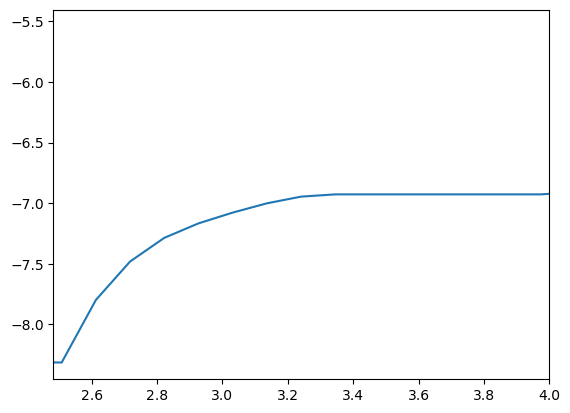

4.7170054655
E126


/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_15423/529184627.py:7: RuntimeWarning: divide by zero encountered in log10
  log10_data = np.log10(data)


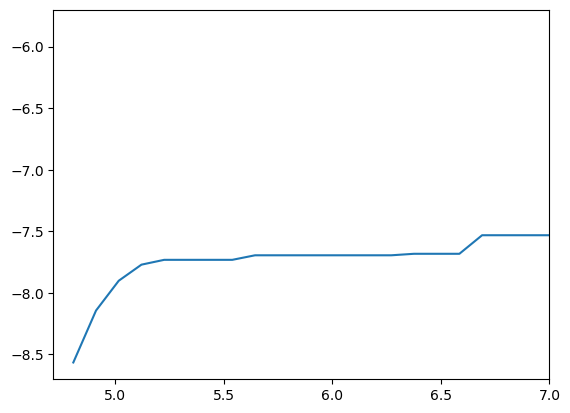

7.03133306538
E108


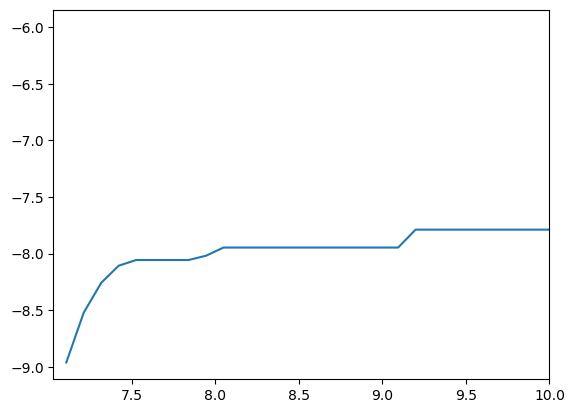

9.35626802307
E90


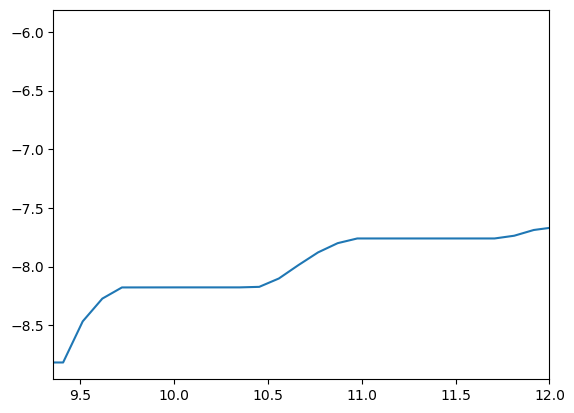

11.6843787945
E72


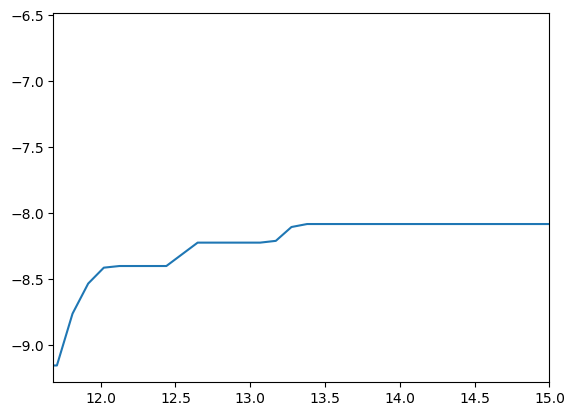

14.0143244145
E54


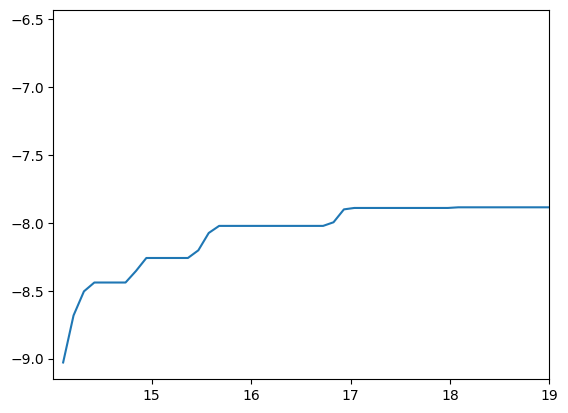

16.2984552166
E36


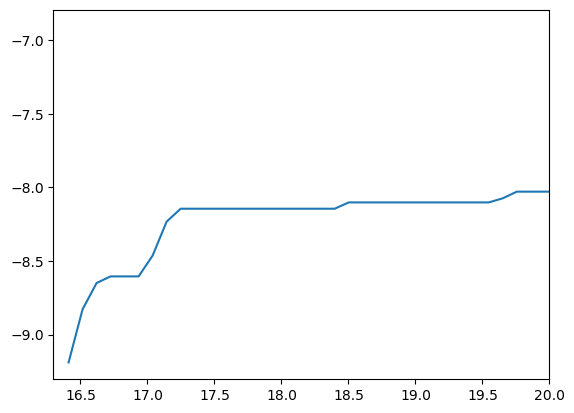

18.5671978329
E18


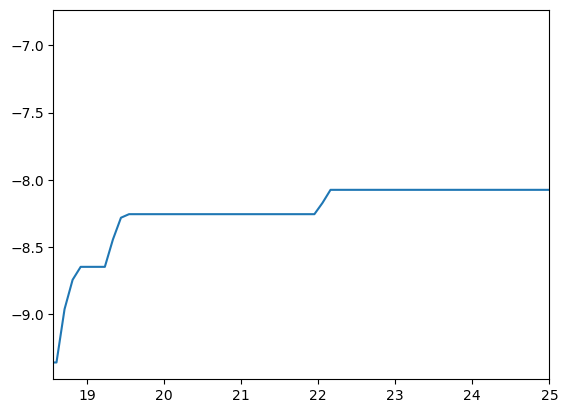

In [43]:
for sta in stas_sub:
    evt_id = 'M5'
    both_peak_strain = np.load(path + 'npys_for_mcmc/' + evt_id + '/filter_peak_strain/' + sta + '.npy')

    times = both_peak_strain[:,0]
    data = both_peak_strain[:,1]
    log10_data = np.log10(data)
    
    i = np.where(stas.name.values == sta)[0]
    theo_p_arr = stas.p_arrival.values[i][0]
    print(theo_p_arr)

    xlow = theo_p_arr
    xhigh = get_xhigh(evt_id, sta)

    print(sta)
    plt.plot(times, log10_data)
    plt.xlim(xlow, xhigh)
    plt.show()